# 4.5 权重衰减

## 4.5.1 高维线性回归

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 4.5.2 从零开始实现

### 4.5.2.1 初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 4.5.2.2 定义L2范数惩罚
实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### 4.5.2.3 定义训练代码实现

In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### 4.5.2.4 忽略正则化直接训练
我们现在用lambd = 0禁用权重衰减后运行这个代码。 注意，这里训练误差有了减少，但测试误差没有减少， 这意味着出现了严重的过拟合。

w的L2范数是： 13.264272689819336


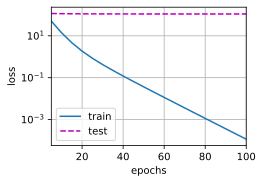

In [8]:
train(lambd=0)

### 4.5.2.5 使用权重衰减

w的L2范数是： 0.36147183179855347


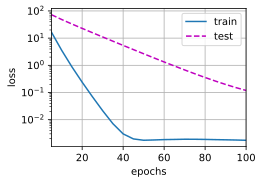

In [9]:
train(lambd=3)

## 4.5.3 简洁实现
由于权重衰减在神经网络优化中很常用， **深度学习框架为了便于我们使用权重衰减， 将权重衰减集成到优化算法中**，以便与任何损失函数结合使用。    
此外，这种集成还有计算上的好处， 允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。 由于更新的权重衰减部分仅依赖于每个参数的当前值， 因此优化器必须至少接触每个参数一次。

In [10]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.501702308654785


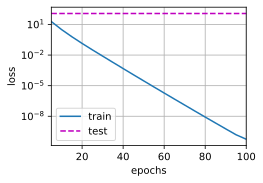

In [12]:
train_concise(0)

w的L2范数： 0.3792768716812134


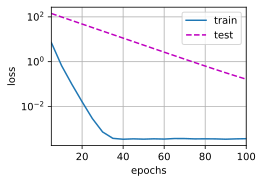

In [13]:
train_concise(3)

Step 1: No Regularization: w = 0.9800
Step 1: L2 Regularization: w = 0.8800
Step 1: L1 Regularization: w = 0.9300
Step 2: No Regularization: w = 0.9600
Step 2: L2 Regularization: w = 0.7720
Step 2: L1 Regularization: w = 0.8600
Step 3: No Regularization: w = 0.9400
Step 3: L2 Regularization: w = 0.6748
Step 3: L1 Regularization: w = 0.7900
Step 4: No Regularization: w = 0.9200
Step 4: L2 Regularization: w = 0.5873
Step 4: L1 Regularization: w = 0.7200
Step 5: No Regularization: w = 0.9000
Step 5: L2 Regularization: w = 0.5086
Step 5: L1 Regularization: w = 0.6500
Step 6: No Regularization: w = 0.8800
Step 6: L2 Regularization: w = 0.4377
Step 6: L1 Regularization: w = 0.5800
Step 7: No Regularization: w = 0.8600
Step 7: L2 Regularization: w = 0.3740
Step 7: L1 Regularization: w = 0.5100
Step 8: No Regularization: w = 0.8400
Step 8: L2 Regularization: w = 0.3166
Step 8: L1 Regularization: w = 0.4400
Step 9: No Regularization: w = 0.8200
Step 9: L2 Regularization: w = 0.2649
Step 9: L1 R

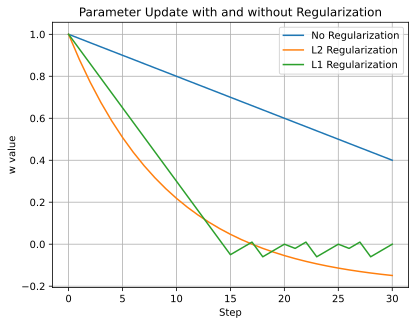

In [17]:
import matplotlib.pyplot as plt

# 初始化参数
w0 = 1.0  # 初始权重
eta = 0.1  # 学习率
lambda_l2 = 0.5
lambda_l1 = 0.5
loss_grad = 0.2  # 假设的loss带来的梯度是固定的

# 记录不同正则方法下的参数轨迹
w_no_reg = [w0]
w_l2 = [w0]
w_l1 = [w0]

# 迭代更新
w1 = w2 = w3 = w0
for i in range(30):
    # 无正则
    w1 = w1 - eta * loss_grad
    w_no_reg.append(w1)
    print(f"Step {i+1}: No Regularization: w = {w1:.4f}")
    
    # L2 正则化：加入额外的 2 * λ * w
    w2 = w2 - eta * (loss_grad + 2 * lambda_l2 * w2)
    w_l2.append(w2)
    print(f"Step {i+1}: L2 Regularization: w = {w2:.4f}")
    
    # L1 正则化：加入 λ * sign(w)
    sign = 1 if w3 > 0 else -1 if w3 < 0 else 0
    w3 = w3 - eta * (loss_grad + lambda_l1 * sign)
    # 添加 soft-thresholding（模拟 0 区间惩罚）
    if abs(w3) < 1e-4:
        w3 = 0
    w_l1.append(w3)
    print(f"Step {i+1}: L1 Regularization: w = {w3:.4f}")

# 画图对比
plt.plot(w_no_reg, label='No Regularization')
plt.plot(w_l2, label='L2 Regularization')
plt.plot(w_l1, label='L1 Regularization')
plt.xlabel('Step')
plt.ylabel('w value')
plt.title('Parameter Update with and without Regularization')
plt.legend()
plt.grid(True)
plt.show()
